In [67]:
import os
import re
from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
# from oneibl.onelight import ONE # only used for downloading data
# import wget
from utils import *
from plotting_utils import *
from analysis_utils import *
import dglm_hmm1
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


ibl_data_path = '../data_IBL'
dfAll = pd.read_csv(ibl_data_path + '/Ibl_processed.csv')
colorsFeatures = [['#FAA61A','indigo','#99CC66','#59C3C3','#9593D9'],['#FAA61A',"#2369BD","#A9373B",'#99CC66','#59C3C3','#9593D9']]
#colorsStates = ['orange','firebrick','forestgreen']#['orange','slateblue','forestgreen'] #['#FAA61A','#59C3C3','#9593D9','#99CC66','indigo'] #['darkorange','darkblue','forestgreen','purple']
colorsStates = ['tab:orange','tab:blue', 'tab:green','tab:red']
myFeatures = [['bias','delta stimulus', 'previous choice', 'previous answer'],['bias','contrast left','contrast right', 'previous choice', 'previous answer']]
sns.set_context("talk")
# colormap = ['rebeccapurple','teal','darkturquoise','springgreen','gold']
# colormap = ['rebeccapurple','royalblue','limegreen','orange']
colormap = ['tab:purple','tab:pink','tab:cyan','yellowgreen']

In [68]:
# identities of labs
subjectsAll = []
colors_labs = ['tab:brown','tab:red','tab:purple']
labChosen =  ['angelakilab','churchlandlab','wittenlab']
dict_subjects = {'angelakilab':[],'churchlandlab':[],'wittenlab':[]}

for lab in labChosen:
    subjects = np.unique(dfAll[dfAll['lab'] == lab]['subject']).tolist()
    subjectsAll = subjectsAll + subjects

if ('NYU-01' in subjectsAll):
    subjectsAll.remove('NYU-01')
if ('NYU-06' in subjectsAll):
    subjectsAll.remove('NYU-06')
if ('CSHL_007' in subjectsAll):
    subjectsAll.remove('CSHL_007')
if ('CSHL049' in subjectsAll):
    subjectsAll.remove('CSHL049')
 
lab_identity = np.ones((len(subjectsAll))).astype(int) * -1

for subject_idx in range(len(subjectsAll)):
    subject = subjectsAll[subject_idx]
    for z in range(len(labChosen)):
        lab = labChosen[z]
        subjects = np.unique(dfAll[dfAll['lab'] == lab]['subject']).tolist()
        if subject in subjects:
            lab_identity[subject_idx] = z

labChosen =  ['angelaki lab','churchland lab','witten lab']

In [69]:
# setting hyperparameters
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))]
alphaList = [2*(10**x) for x in list(np.arange(-1,6,0.5,dtype=float))] 
L2penaltyW = 1
maxiter = 200
bestSigma = 1 # verified from fitting multiple sigmas
bestSigmaInd = 7
bestAlpha = 2
bestAlphaInd = 2 # equivalent to alpha=2
priorDirP = [100,10] # to read dGLMHMM1 model
fit_init_states = False
K = 3
D = 4 # number of features
sessStop = -1 # last session to use in fitting
splitFolds = 5
inits = 21

# Figure 6A

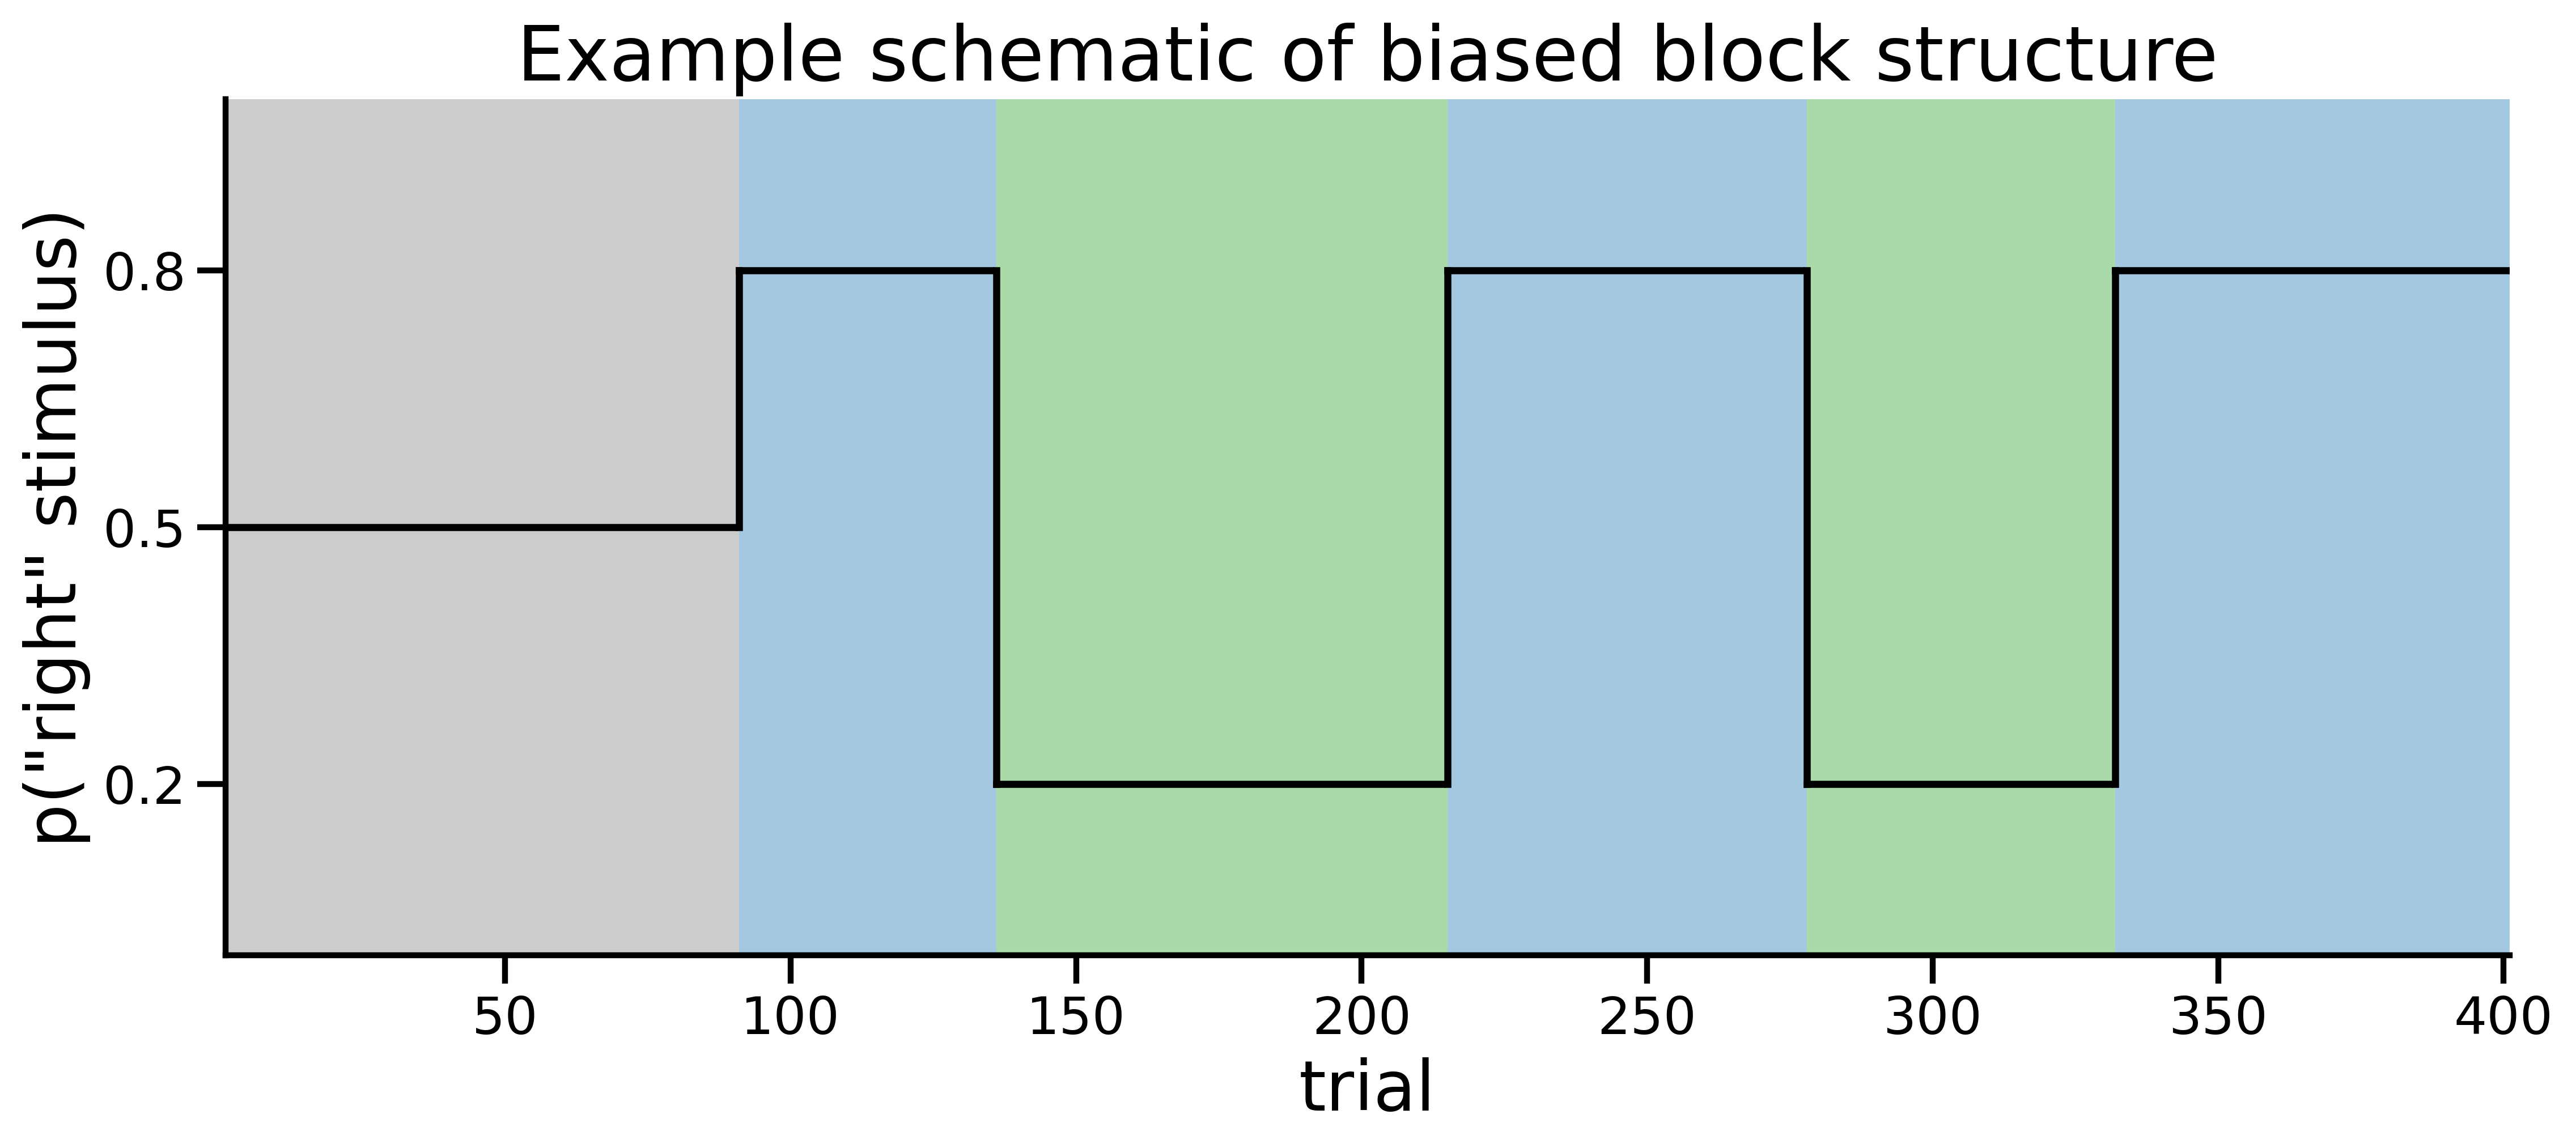

In [70]:
from matplotlib.patches import Rectangle
fig, axes = plt.subplots(1, figsize = (13,5), sharex=True, dpi=400) 
N_trials = 408

axes.plot(range(1,91), np.ones((90)) * 0.5, color='black')
axes.plot([91,91],[0.5,0.8], color='black')
axes.plot(range(91,136), np.ones((45)) * 0.8, color='black')
axes.plot([136,136],[0.2,0.8], color='black')
axes.plot(range(136,215), np.ones((79)) * 0.2, color='black')
axes.plot([215,215],[0.2,0.8], color='black')
axes.plot(range(215,278), np.ones((63)) * 0.8, color='black')
axes.plot([278,278],[0.2,0.8], color='black')
axes.plot(range(278,332), np.ones((54)) * 0.2, color='black')
axes.plot([332,332],[0.2,0.8], color='black')
axes.plot(range(332,408), np.ones((76)) * 0.8, color='black')

axes.add_patch(Rectangle((1, 0), 90, 1, facecolor='gray', fill=True, alpha=0.4, zorder=0))
axes.add_patch(Rectangle((91, 0), 45, 1, facecolor='tab:blue', fill=True, alpha=0.4, zorder=0))
axes.add_patch(Rectangle((136, 0), 79, 1, facecolor='tab:green', fill=True, alpha=0.4, zorder=0))
axes.add_patch(Rectangle((215, 0), 63, 1, facecolor='tab:blue', fill=True, alpha=0.4, zorder=0))
axes.add_patch(Rectangle((278, 0), 54, 1, facecolor='tab:green', fill=True, alpha=0.4, zorder=0))
axes.add_patch(Rectangle((332, 0), 76, 1, facecolor='tab:blue', fill=True, alpha=0.4, zorder=0))

axes.set_ylabel('p("right" stimulus)', size=22)
axes.set_ylim(0,1)
axes.set_yticks([0.2,0.5,0.8],[0.2,0.5,0.8])
axes.set_xlabel('trial', size=22)
axes.spines[['right', 'top']].set_visible(False)
axes.set_xticks(range(50,450,50),range(50,450,50))
axes.set_title('Example schematic of biased block structure', size=24)
axes.set_xlim(1,401)
plt.savefig(f'../figures/Example_session_block_structure', bbox_inches='tight', dpi=400)

In [71]:
# loading best 3-state models
allW = np.empty((len(subjectsAll)), dtype=object)
allP = np.empty((len(subjectsAll)), dtype=object)

for idx in range(0,len(subjectsAll)):
    subject=subjectsAll[idx]
    _, _, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D)
    param = np.load(f'../data_IBL/{subject}/{subject}_ALL-PARAM_D={D}_{K}_state_alpha={bestAlpha}_multiple-initsP_L2penaltyW={L2penaltyW}_untilSession{sessStop}.npz')
    allP[idx] =  param['allP'][0] # starting from best dynamic GLMHMM fit with constant P and dynamic W
    allW[idx] =  param['allW'][0] # starting from best dynamic GLMHMM fit with constant P and dynamic W
    

In [72]:
# computing task performance in right vs left blocks
rightBiasPerformance = np.empty((len(subjectsAll)), dtype=object)
leftBiasPerformance = np.empty((len(subjectsAll)), dtype=object)

for idx in range(0, len(subjectsAll)):
    subject = subjectsAll[idx]
    x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D) 
    biasedBlockTrials, biasedBlockStartInd, biasedBlockSession, firstBlockSession = get_design_biased_blocks(dfAll, subject, sessInd, sessStop)
    N = x.shape[0]

    correctChoice = (y == correctSide).astype(int) # 1 if animal made correct choice
    sess = len(sessInd)-1
    rightBiasPerformance[idx] = np.zeros((sess))
    leftBiasPerformance[idx] = np.zeros((sess))
    for s in range(0,sess):
        biasedRight = (biasedBlockTrials[sessInd[s]:sessInd[s+1]]==1)
        if biasedRight.sum() > 0:
            rightBiasPerformance[idx][s] = correctChoice[sessInd[s]+np.argwhere(biasedRight==True)].sum() / biasedRight.sum()
        else: 
            rightBiasPerformance[idx][s] = np.nan
        
        biasedLeft = (biasedBlockTrials[sessInd[s]:sessInd[s+1]]==-1)
        if biasedLeft.sum() > 0:
            leftBiasPerformance[idx][s] = correctChoice[sessInd[s]+np.argwhere(biasedLeft==True)].sum() / biasedLeft.sum()
        else: 
            leftBiasPerformance[idx][s] = np.nan


# Figure 6B

/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_45501/615803692.py:8: RuntimeWarning: Mean of empty slice
  axes.scatter(np.nanmean(rightBiasPerformance[idx])*100, np.nanmean(leftBiasPerformance[idx])*100, color=colors_labs[int(lab_identity[idx])], alpha=0.9)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_45501/615803692.py:6: RuntimeWarning: Mean of empty slice
  axes.scatter(np.nanmean(rightBiasPerformance[idx])*100, np.nanmean(leftBiasPerformance[idx])*100, c=colors_labs[int(lab_identity[idx])], alpha=0.9, label=labChosen[int(lab_identity[idx])])


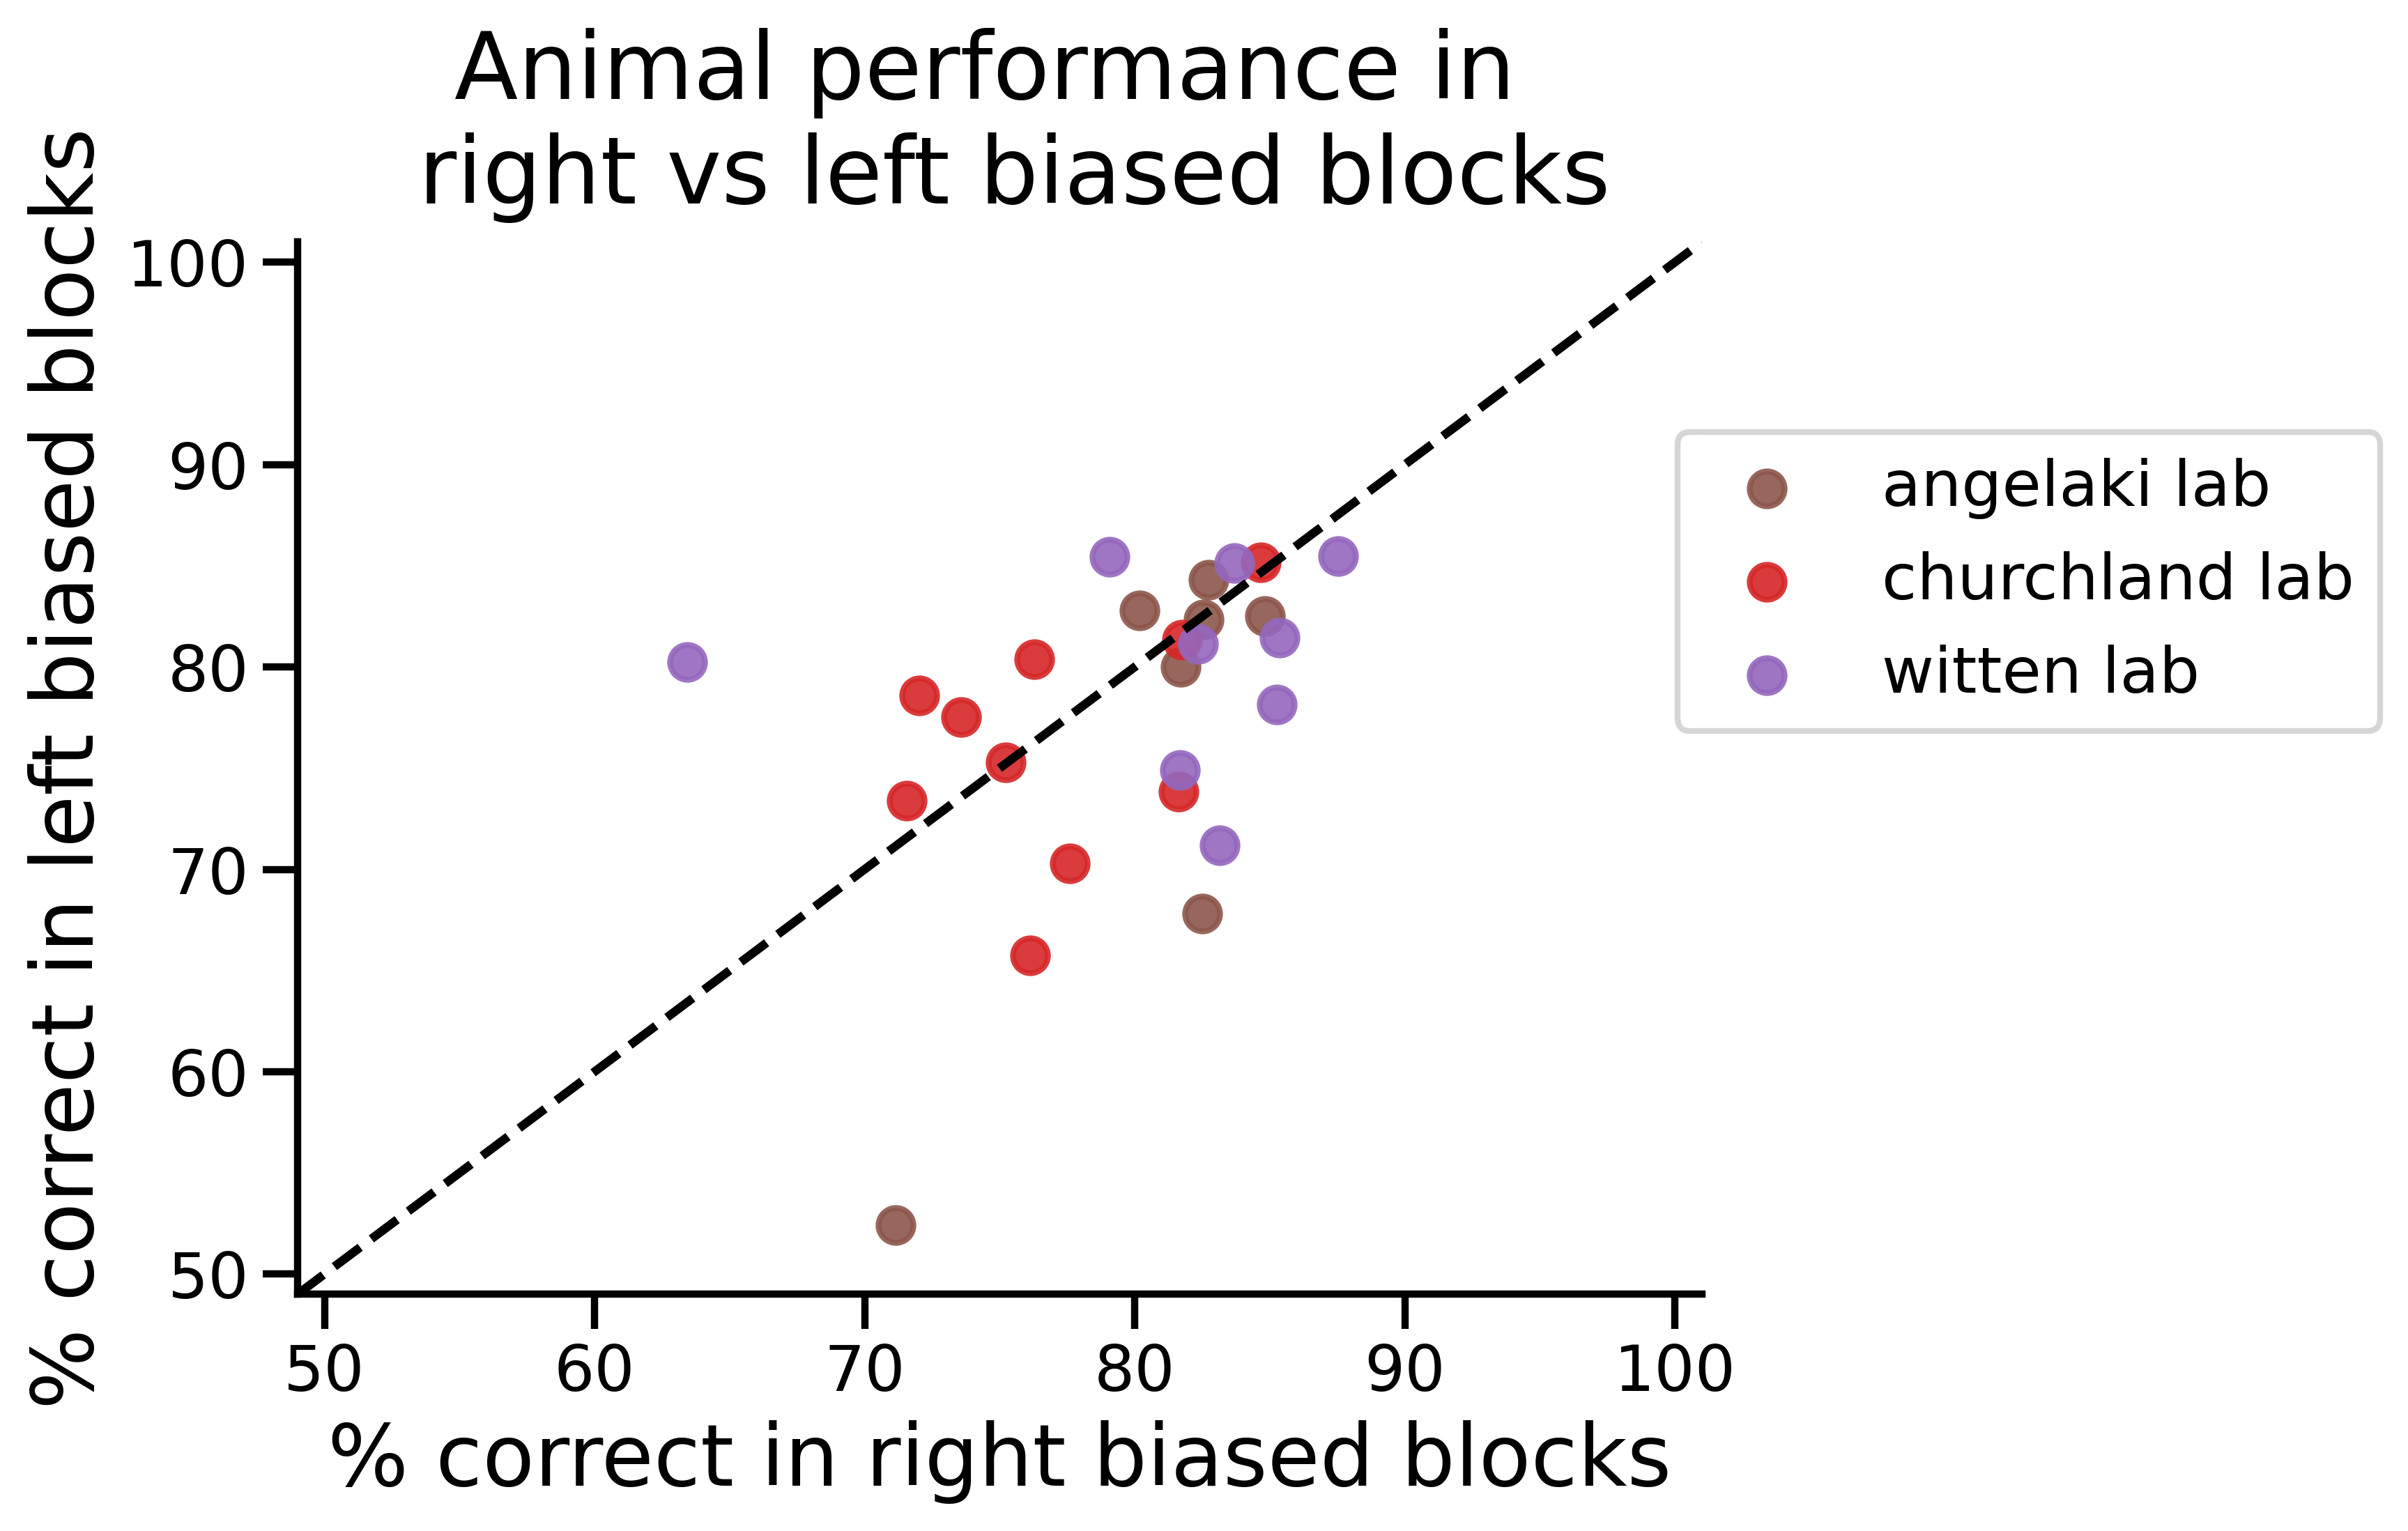

In [73]:
fig, axes = fig, axes = plt.subplots(1, figsize = (6.5,5), dpi=400)
axes.set_xlabel('% correct in right biased blocks', size=22)
axes.set_ylabel('% correct in left biased blocks', size=22)
for idx in range(0,len(subjectsAll)):
    if idx in [0,15,30]:
        axes.scatter(np.nanmean(rightBiasPerformance[idx])*100, np.nanmean(leftBiasPerformance[idx])*100, c=colors_labs[int(lab_identity[idx])], alpha=0.9, label=labChosen[int(lab_identity[idx])])
    else:
        axes.scatter(np.nanmean(rightBiasPerformance[idx])*100, np.nanmean(leftBiasPerformance[idx])*100, color=colors_labs[int(lab_identity[idx])], alpha=0.9)
axes.set_xlim(49,101)
axes.set_ylim(49,101)
axes.plot([0, 1], [0, 1], transform=axes.transAxes, linestyle='dashed', color='black')
axes.spines[['right', 'top']].set_visible(False)
axes.set_title('Animal performance in \n right vs left biased blocks', size=24, pad=10)
axes.legend(bbox_to_anchor=(0.96, 0.85))
plt.savefig(f'../figures/Correct_Right_Vs_Left_ScatterPlot', bbox_inches='tight', dpi=400)

In [74]:
# Computing posterior probability of latent states across animals
allGamma = np.empty((len(subjectsAll)), dtype=object)
truepi = np.ones((K))
for idx in range(0,len(subjectsAll)):
    subject=subjectsAll[idx]
    x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D)
    N = sessInd[-1]
    presentAll = np.ones((N))
    dGLM_HMM = dglm_hmm2.dGLM_HMM2(N,K,D,2)
    allGamma[idx] = dGLM_HMM.get_posterior_latent(allP[idx], truepi, allW[idx], x, y, presentAll, sessInd, sortedStateInd=None)

In [75]:
# computing observation probabilities across animals
allPhi = np.empty((len(subjectsAll)), dtype=object) 
for idx in range(0,len(subjectsAll)):
    subject=subjectsAll[idx]
    x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D)
    N = sessInd[-1]
    dGLMHMM2 = dglm_hmm2.dGLM_HMM2(N,K,D,2)
    allPhi[idx] = dGLMHMM2.observation_probability(x, allW[idx])

In [76]:
# computing per-state occupancy and accuracy across animals
allStateCount = np.empty((len(subjectsAll)), dtype=object)
allStateCorrect = np.empty((len(subjectsAll)), dtype=object)
allOverallCorrect = np.empty((len(subjectsAll)), dtype=object)
blocksStateRight = np.empty((len(subjectsAll)), dtype=object)
blocksStateLeft = np.empty((len(subjectsAll)), dtype=object)

fig, axes = plt.subplots(1, figsize = (14,5))
for idx in range(0,len(subjectsAll)):
    subject = subjectsAll[idx]
    x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D)
    biasedBlockTrials, biasedBlockStartInd, biasedBlockSession, firstBlockSession = get_design_biased_blocks(dfAll, subject, sessInd, sessStop)
    axes.set_title(subject)
    allStateCount[idx] = plot_state_occupancy_sessions(allGamma[idx], sessInd, axes, colors=colorsStates)
    axes.set_ylim(-1,101)

    axes.set_title(subject)
    _, _, allOverallCorrect[idx], allStateCorrect[idx] = accuracy_states_sessions(allGamma[idx], allPhi[idx], y, correctSide, sessInd)
    axes.set_ylim(40,100)
  
    blocksStateRight[idx], blocksStateLeft[idx] = plot_aligned_fraction_blocks_state(allGamma[idx], sessInd, biasedBlockTrials, biasedBlockSession, axes)
    axes.axvline(firstBlockSession+1, color='gray', zorder=0)

plt.close()

/Volumes/Lenca_SSD/github/Pillow_dGLM-HMM/code/plotting_utils.py:351: RuntimeWarning: Mean of empty slice
  axes.plot(range(1,len(sessInd)), np.nanmean(np.array([blocksStateRight,blocksStateLeft]),axis=0), color='black',label='mean')
/Volumes/Lenca_SSD/github/Pillow_dGLM-HMM/code/plotting_utils.py:351: RuntimeWarning: Mean of empty slice
  axes.plot(range(1,len(sessInd)), np.nanmean(np.array([blocksStateRight,blocksStateLeft]),axis=0), color='black',label='mean')
/Volumes/Lenca_SSD/github/Pillow_dGLM-HMM/code/plotting_utils.py:351: RuntimeWarning: Mean of empty slice
  axes.plot(range(1,len(sessInd)), np.nanmean(np.array([blocksStateRight,blocksStateLeft]),axis=0), color='black',label='mean')
/Volumes/Lenca_SSD/github/Pillow_dGLM-HMM/code/plotting_utils.py:351: RuntimeWarning: Mean of empty slice
  axes.plot(range(1,len(sessInd)), np.nanmean(np.array([blocksStateRight,blocksStateLeft]),axis=0), color='black',label='mean')
/Volumes/Lenca_SSD/github/Pillow_dGLM-HMM/code/plotting_utils.py

# Figure 6C

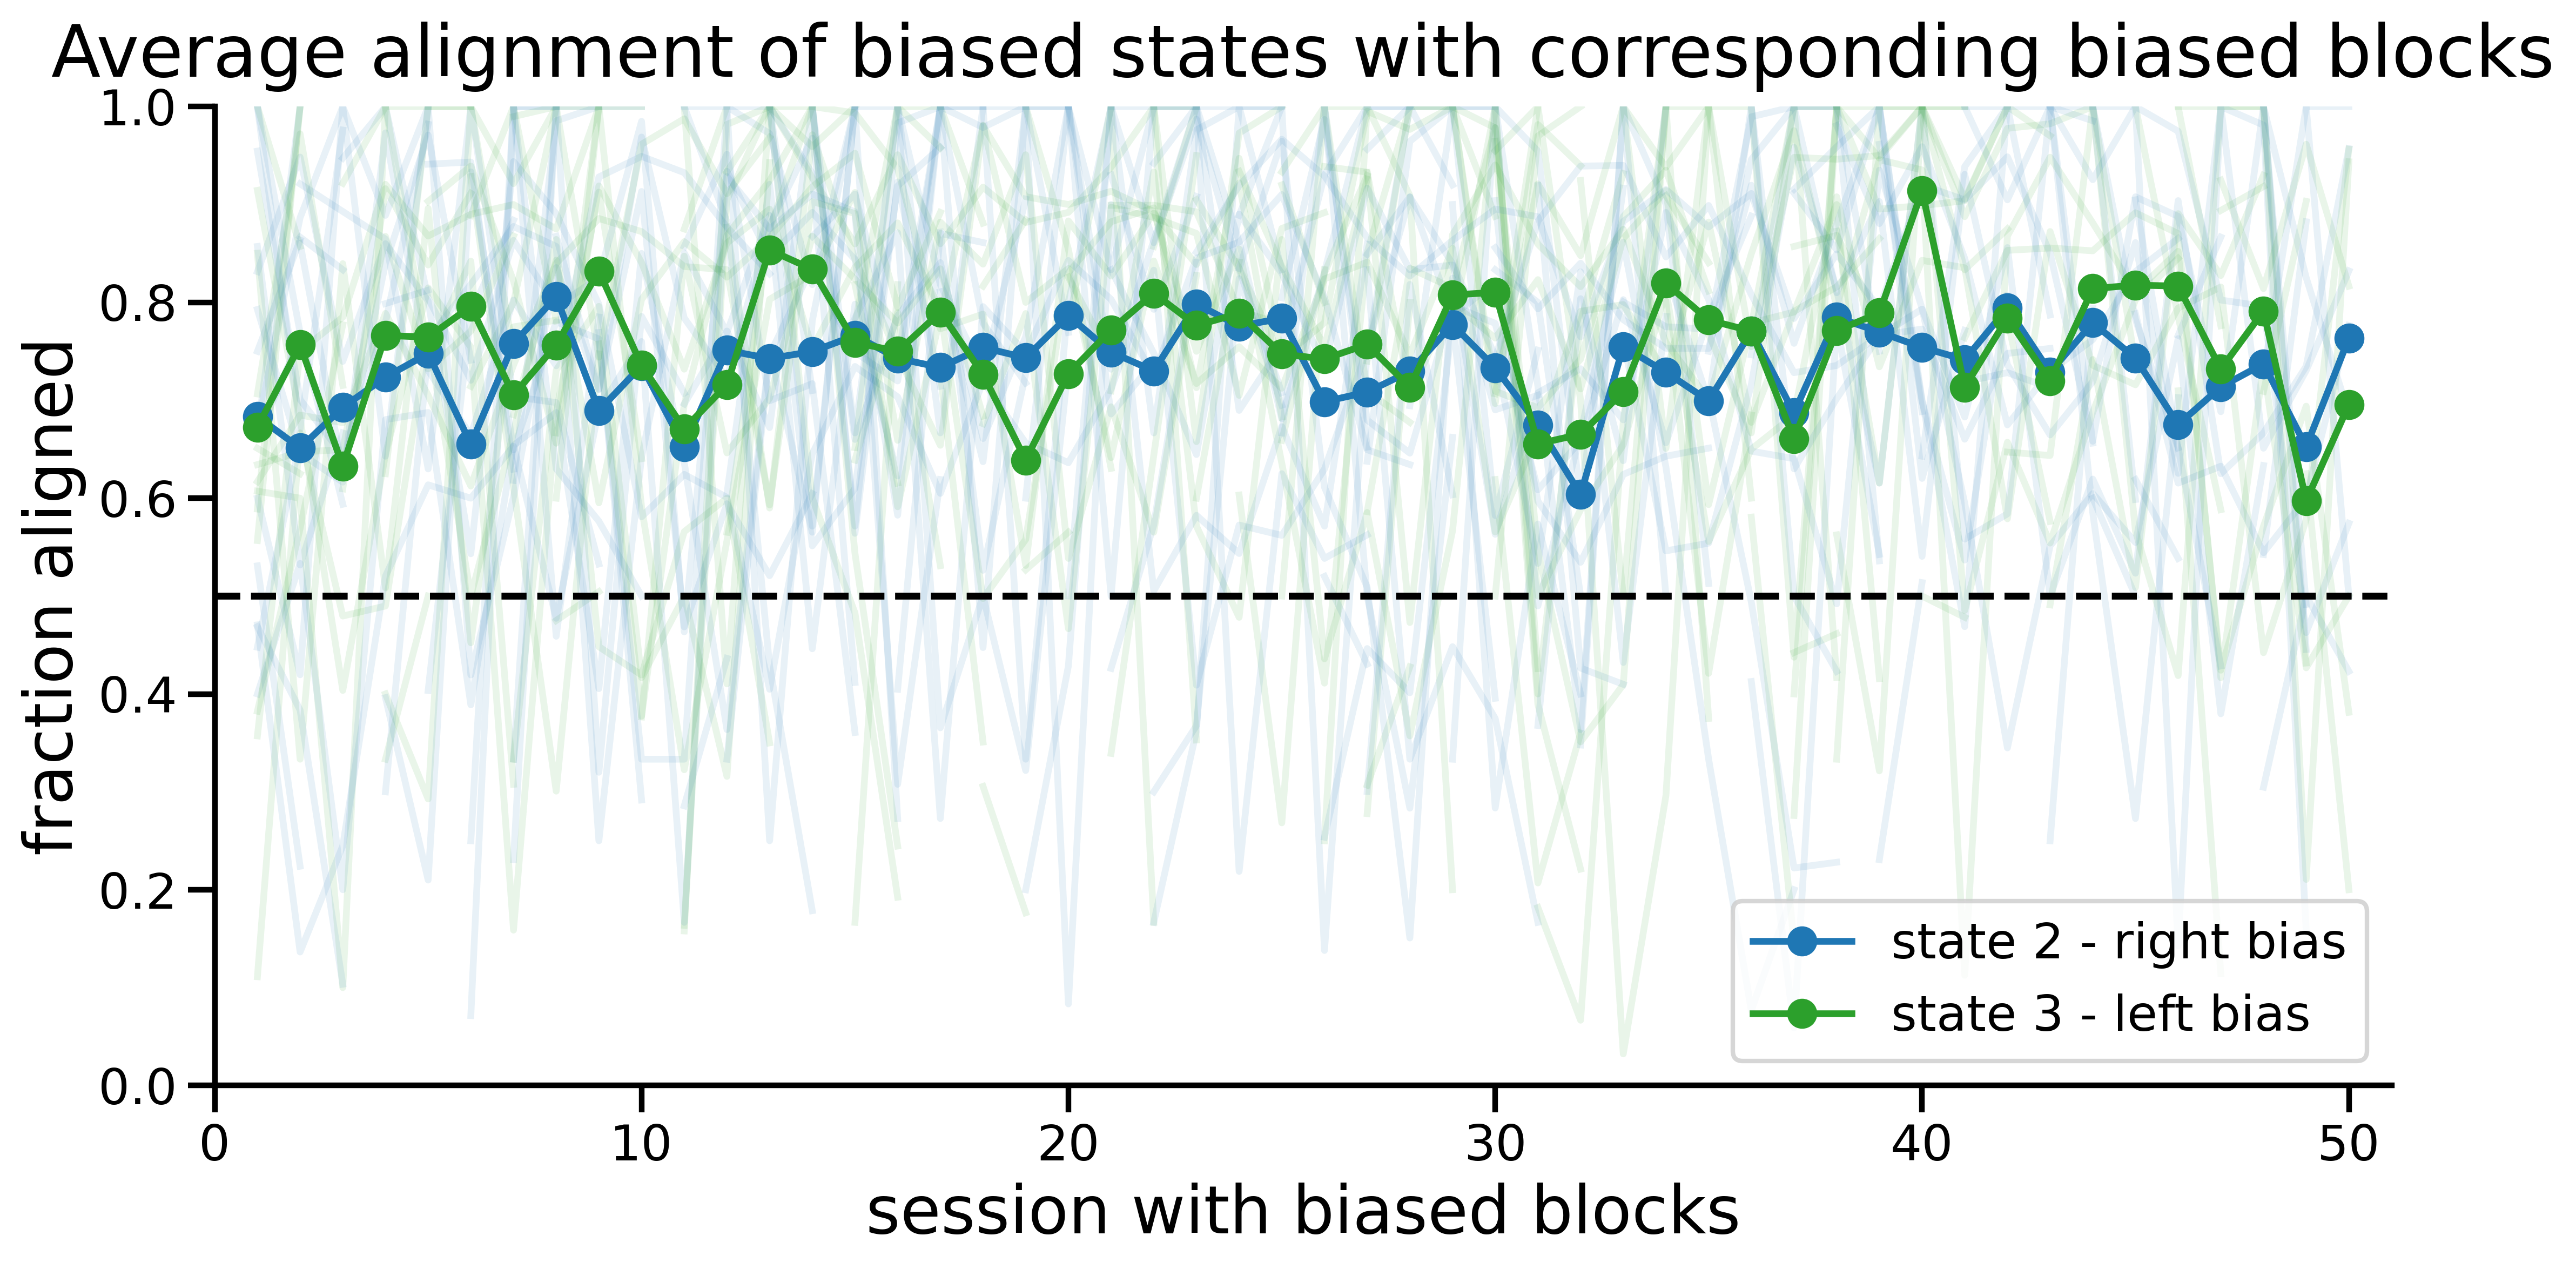

In [77]:
# Average across animals of bias-block alignment with first biased session aligned across animals
maxSess = 50

arrAlignRight = np.ma.empty((maxSess,len(subjectsAll)))
arrAlignRight.mask = True

arrAlignLeft = np.ma.empty((maxSess,len(subjectsAll)))
arrAlignLeft.mask = True

fig, axes = plt.subplots(1, figsize = (13,6), dpi=400)
axes.axhline(0.5,color='gray',linestyle='dashed')
axes.set_title('Average alignment of biased states with corresponding biased blocks', size=24, pad=10)
for idx in range(0,len(subjectsAll)):
    subject = subjectsAll[idx] 
    _, _, sessInd, _ = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D)
    _, _, _, firstBlockSession = get_design_biased_blocks(dfAll, subject, sessInd, sessStop)
    if (np.isnan(firstBlockSession) == False):
        stop = min(len(sessInd)-1, firstBlockSession+maxSess)
        arrAlignRight[:stop-firstBlockSession, idx] = blocksStateRight[idx][firstBlockSession:stop]
        arrAlignLeft[:stop-firstBlockSession, idx] = blocksStateLeft[idx][firstBlockSession:stop]
    
    axes.plot(range(1,maxSess+1), arrAlignRight[:,idx], '-', color=colorsStates[1], alpha=0.1)
    axes.plot(range(1,maxSess+1),  arrAlignLeft[:,idx], '-', color=colorsStates[2], alpha=0.1)
        
axes.plot(range(1,maxSess+1), np.nanmean(arrAlignRight[:,:], axis=1), '-o', color=colorsStates[1], label='state 2 - right bias', alpha=1)
axes.plot(range(1,maxSess+1), np.nanmean(arrAlignLeft[:,:], axis=1), '-o', color=colorsStates[2], label='state 3 - left bias', alpha=1)
axes.legend()
axes.set_xlim(0,maxSess+1)
axes.axhline(0.5,color='black',linestyle='dashed')
axes.set_ylim(0,1)
axes.set_xlabel('session with biased blocks', size=22)
axes.set_ylabel('fraction aligned', size=22)
axes.spines[['right', 'top']].set_visible(False)
plt.savefig(f'../figures/Fraction_Aligned_States-and-Blocks_allAnimals', bbox_inches='tight', dpi=400)


# Figure 6D

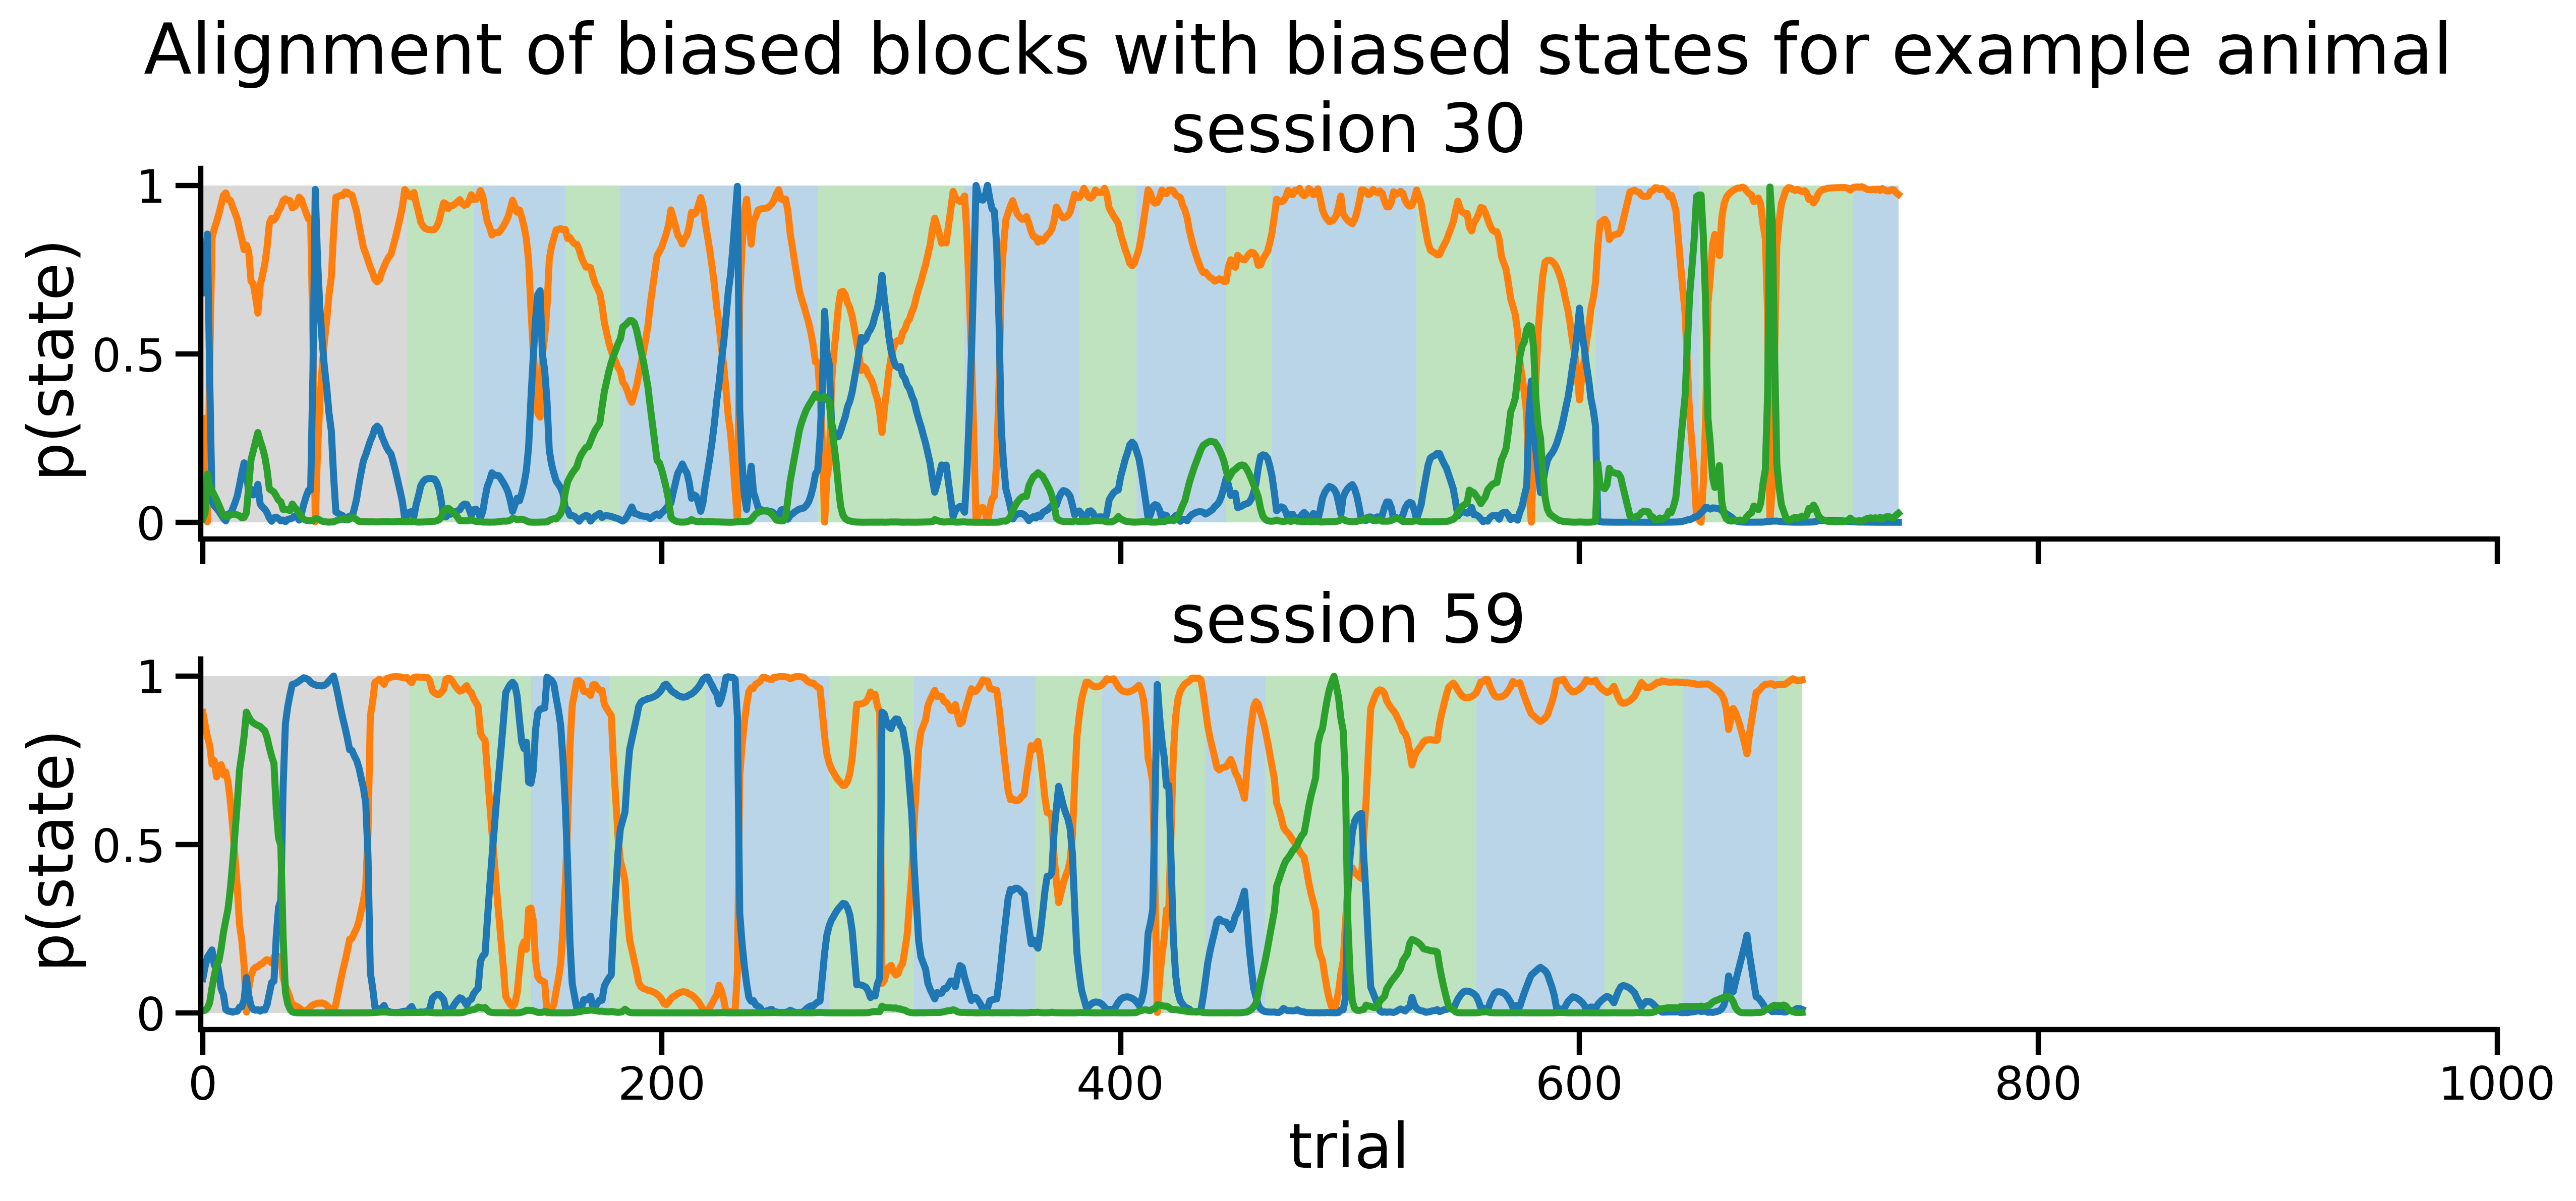

In [93]:
example_subject = 'ibl_witten_015'
example_idx_subject = 30
subject = subjectsAll[example_idx_subject]
subject = subjectsAll[idx]
x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D) 
biasedBlockTrials, biasedBlockStartInd, biasedBlockSession, firstBlockSession = get_design_biased_blocks(dfAll, subject, sessInd, sessStop)
    
sessionsInterest = [29,58]#,27,28,37,40,56,57,58,59,60,61,62,63,64,65,66,67,68,69]
dict_colors = {0:'gray',1:'tab:blue',-1:'tab:green'}
fig, axes = plt.subplots(len(sessionsInterest), 1, figsize=(13,5.5), dpi=400, sharex=True)
fig.tight_layout(pad=1.5)
plot_posteior_latent(allGamma[example_idx_subject], sessInd, axes, sessions = sessionsInterest, linewidth=2.5)
for s in range(0,len(sessionsInterest)):
    sess = sessionsInterest[s]
    flag = 0
    old = sessInd[sess]
    for t in range(sessInd[sess],sessInd[sess+1]):
        if biasedBlockTrials[t] != flag:
            axes[s].add_patch(Rectangle((old-sessInd[sess], 0), t-old, 1, facecolor=dict_colors[flag], fill=True, alpha=0.3, zorder=0))
            old = t
            flag = biasedBlockTrials[t]
    # last biased block
    axes[s].add_patch(Rectangle((old-sessInd[sess], 0), sessInd[sess+1]-1-old, 1, facecolor=dict_colors[flag], fill=True, alpha=0.3, zorder=0))       
    
    axes[s].set_xlim(-1,1000)
    axes[s].spines[['right', 'top']].set_visible(False)
    axes[s].get_legend().remove()
    axes[s].set_ylabel('p(state)', size=22)
    axes[s].set_yticks([0,0.5,1],[0,0.5,1])
axes[-1].set_xlabel('trial', size=22)
fig.suptitle('Alignment of biased blocks with biased states for example animal', size=25, y=1.05)
# fig.tight_layout()
plt.savefig(f'../figures/posterior_latent_example-sessions_{subject}_biased-blocks', bbox_inches='tight', dpi=400)


# Figure 6E

/Users/lencacuturela/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1550: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/lencacuturela/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1550: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/lencacuturela/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1550: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


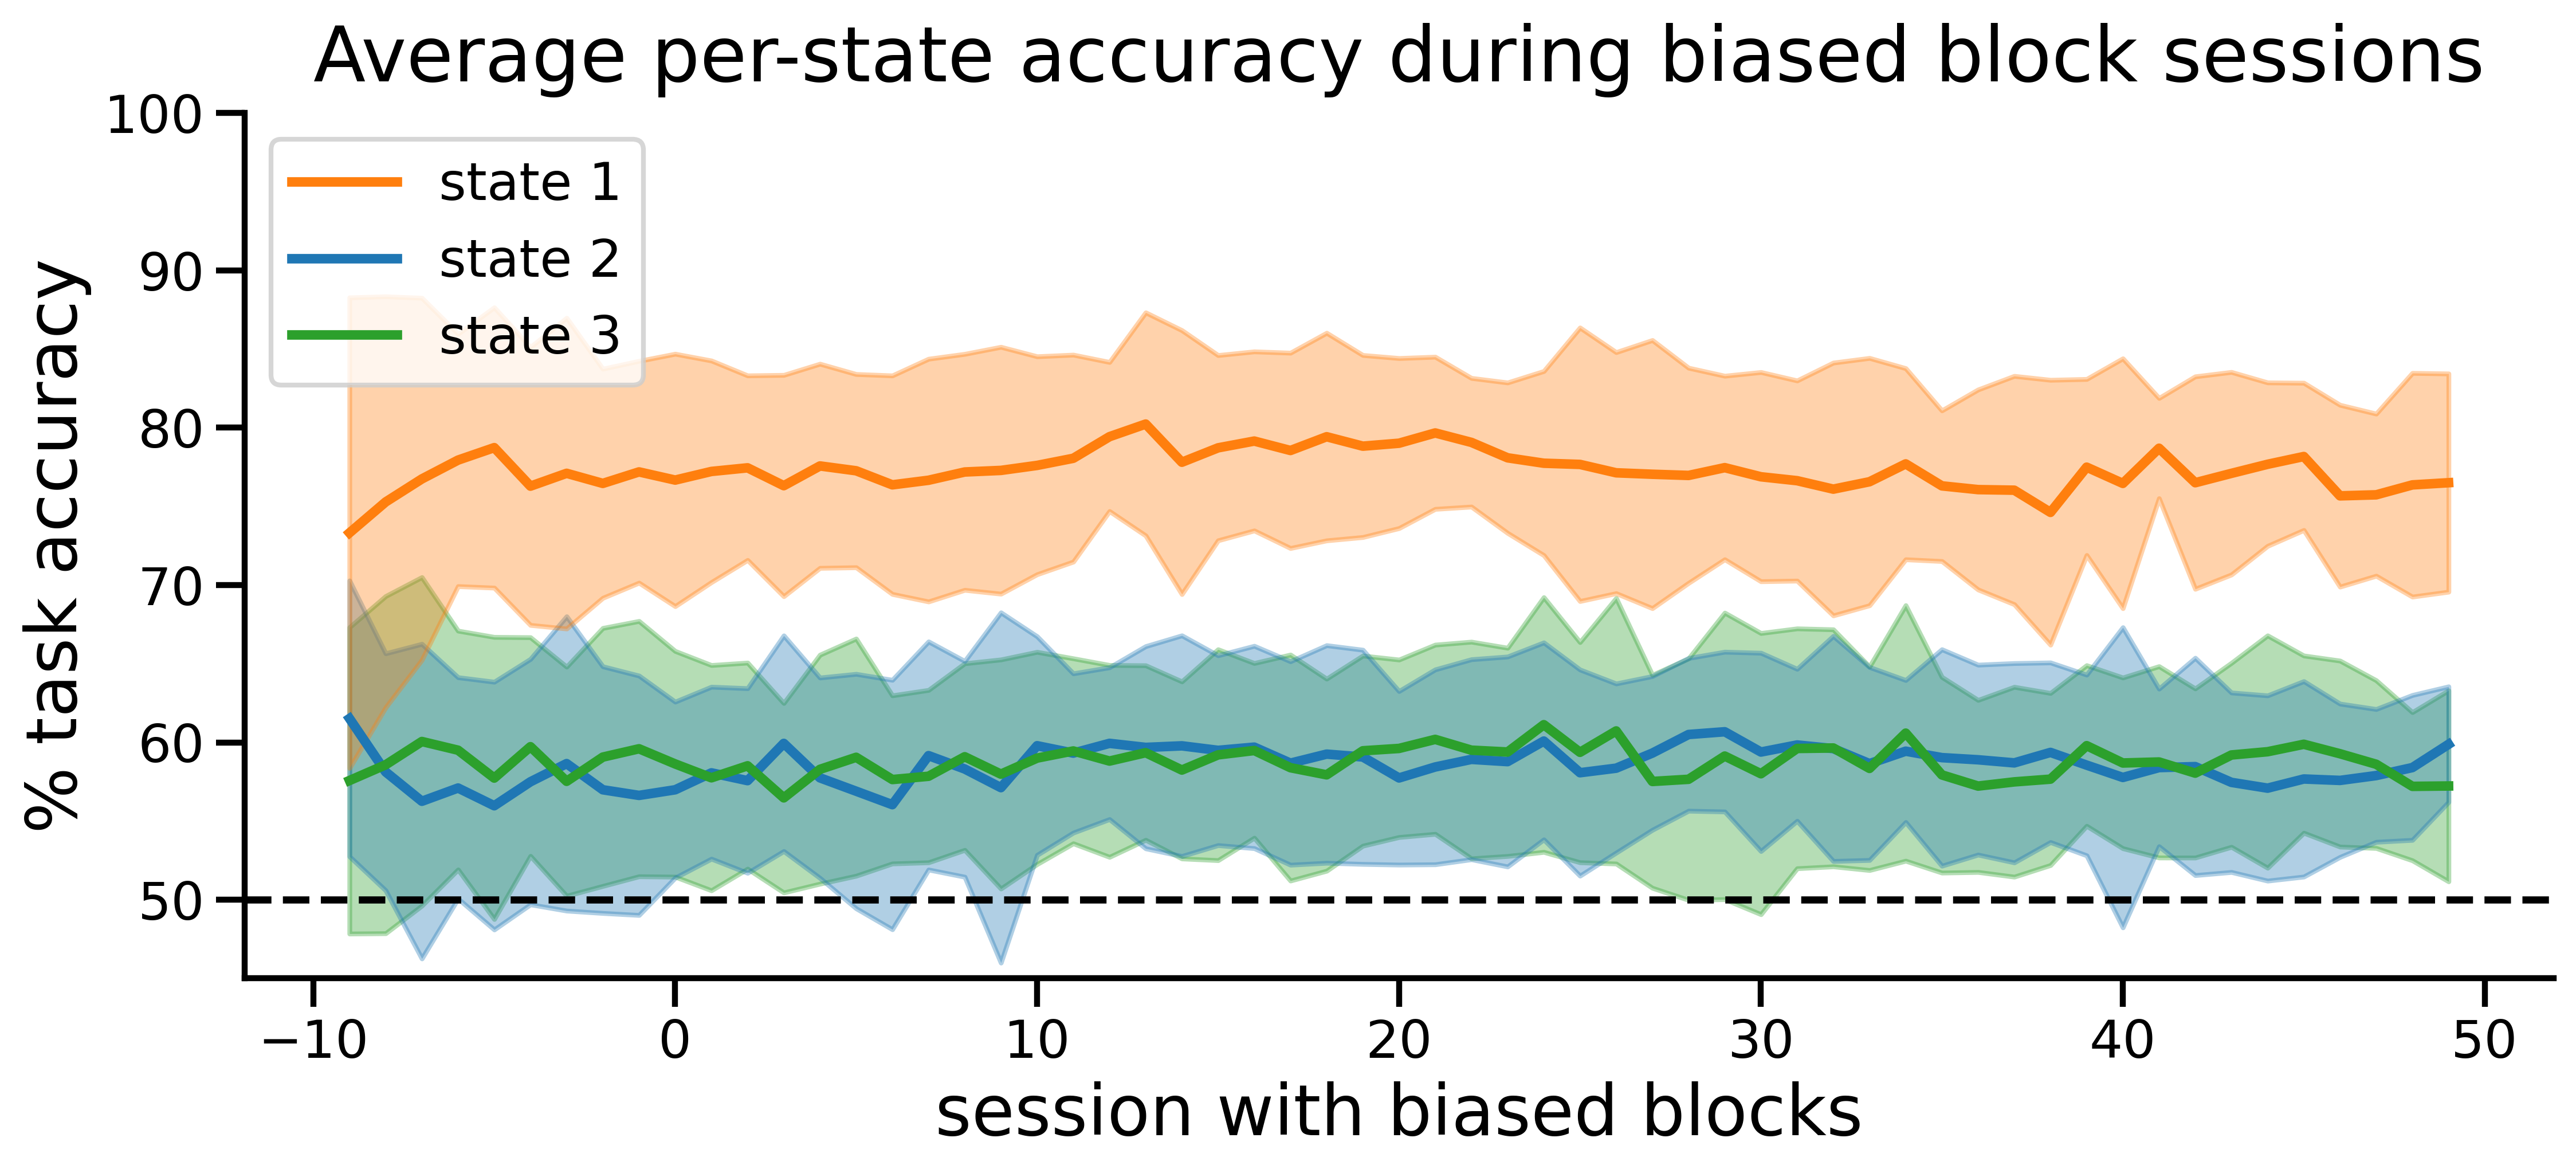

In [84]:
# computing per-state accuracy aligned to start of biased blocks
arrStateCorrect = np.ma.empty((maxSess+9,K,len(subjectsAll)))
arrStateCorrect.mask = True

for idx in range(0,len(subjectsAll)):
    subject = subjectsAll[idx] 
    _, _, sessInd, _ = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D)
    _, _, _, firstBlockSession = get_design_biased_blocks(dfAll, subject, sessInd, sessStop)

    if (np.isnan(firstBlockSession) == False and firstBlockSession >= 9):
        stop = min(len(sessInd)-1, firstBlockSession+maxSess)
        arrStateCorrect[:stop-firstBlockSession+9, :K, idx] = allStateCorrect[idx][firstBlockSession-9:stop]

fig, axes = plt.subplots(1, figsize = (13, 5), dpi=400) 
axes.axhline(50, color='black', linestyle='dashed')
for k in range(0,K):
    axes.plot(range(-9,maxSess), np.nanmean(arrStateCorrect[:,k,:], axis=1), color=colorsStates[k], linewidth=3, label=f'state {k+1}', zorder=3)
    axes.fill_between(range(-9,maxSess), np.nanmean(arrStateCorrect[:,k,:], axis=1)-np.nanstd(arrStateCorrect[:,k,:], axis=1), np.nanmean(arrStateCorrect[:,k,:], axis=1)+np.nanstd(arrStateCorrect[:,k,:], axis=1), alpha=0.35, zorder=2-k, color=colorsStates[k])
axes.set_ylabel('% task accuracy', size=22)
axes.set_xlabel('session with biased blocks', size=22)
axes.set_ylim(45,100)
axes.legend(loc='upper left')
axes.spines[['right', 'top']].set_visible(False)
axes.set_title('Average per-state accuracy during biased block sessions', size=24, pad=10)
plt.savefig(f'../figures/Accuracy_states_allAnimals_biasblocks', bbox_inches='tight', dpi=400)

# Figure 6F

/Users/lencacuturela/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1550: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/lencacuturela/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1550: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/lencacuturela/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1550: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


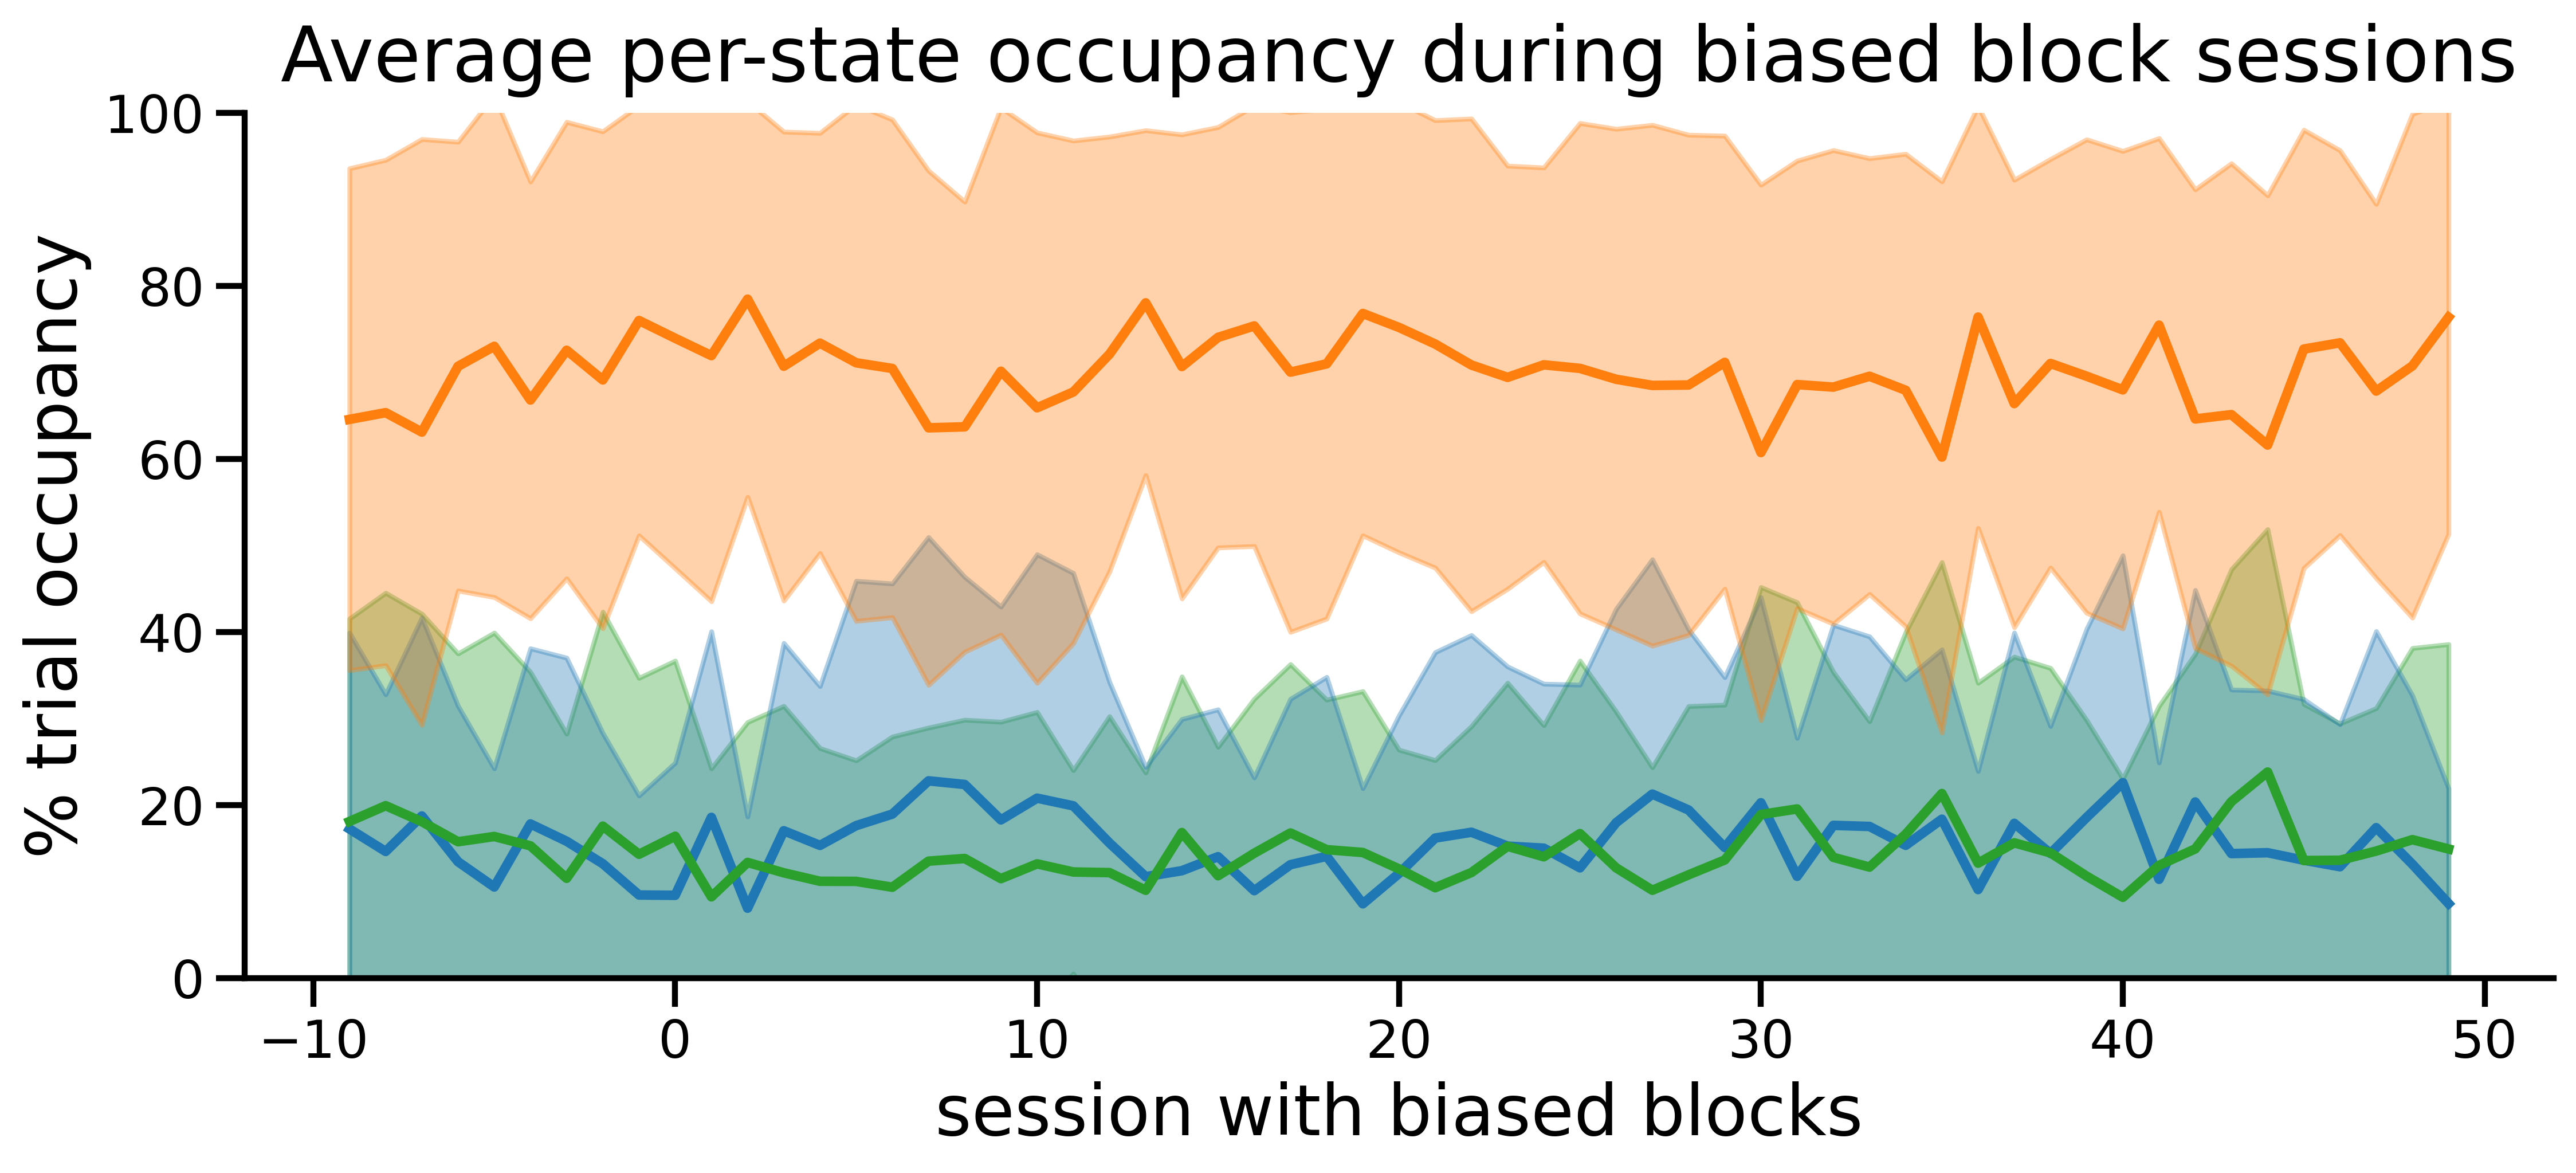

In [85]:
# computing per-state occupancy aligned to start of biased blocks
arrStateCount = np.ma.empty((maxSess+9,K,len(subjectsAll)))
arrStateCount.mask = True

for idx in range(0,len(subjectsAll)):
    subject = subjectsAll[idx] 
    _, _, sessInd, _ = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D)
    _, _, _, firstBlockSession = get_design_biased_blocks(dfAll, subject, sessInd, sessStop)
    if (np.isnan(firstBlockSession) == False and firstBlockSession >= 9):
        stop = min(len(sessInd)-1, firstBlockSession+maxSess)
        arrStateCount[:stop-firstBlockSession+9, :K, idx] = allStateCount[idx][firstBlockSession-9:stop]

fig, axes = plt.subplots(1, figsize = (13, 5), dpi=400) 
for k in range(0,K):
    axes.plot(range(-9,maxSess), np.nanmean(arrStateCount[:,k,:], axis=1), color=colorsStates[k], linewidth=3, label=f'state {k+1}', zorder=3)
    axes.fill_between(range(-9,maxSess), np.nanmean(arrStateCount[:,k,:], axis=1)-np.nanstd(arrStateCount[:,k,:], axis=1), np.nanmean(arrStateCount[:,k,:], axis=1)+np.nanstd(arrStateCount[:,k,:], axis=1), alpha=0.35, zorder=2-k, color=colorsStates[k])

axes.set_ylabel('% trial occupancy', size=22)
axes.spines[['right', 'top']].set_visible(False)
axes.set_xlabel('session with biased blocks', size=22)
axes.set_ylim(0,100)
axes.set_title('Average per-state occupancy during biased block sessions', size=24, pad=10)
plt.savefig(f'../figures/Occupancy_states_allAnimals_biasblocks', bbox_inches='tight', dpi=400)




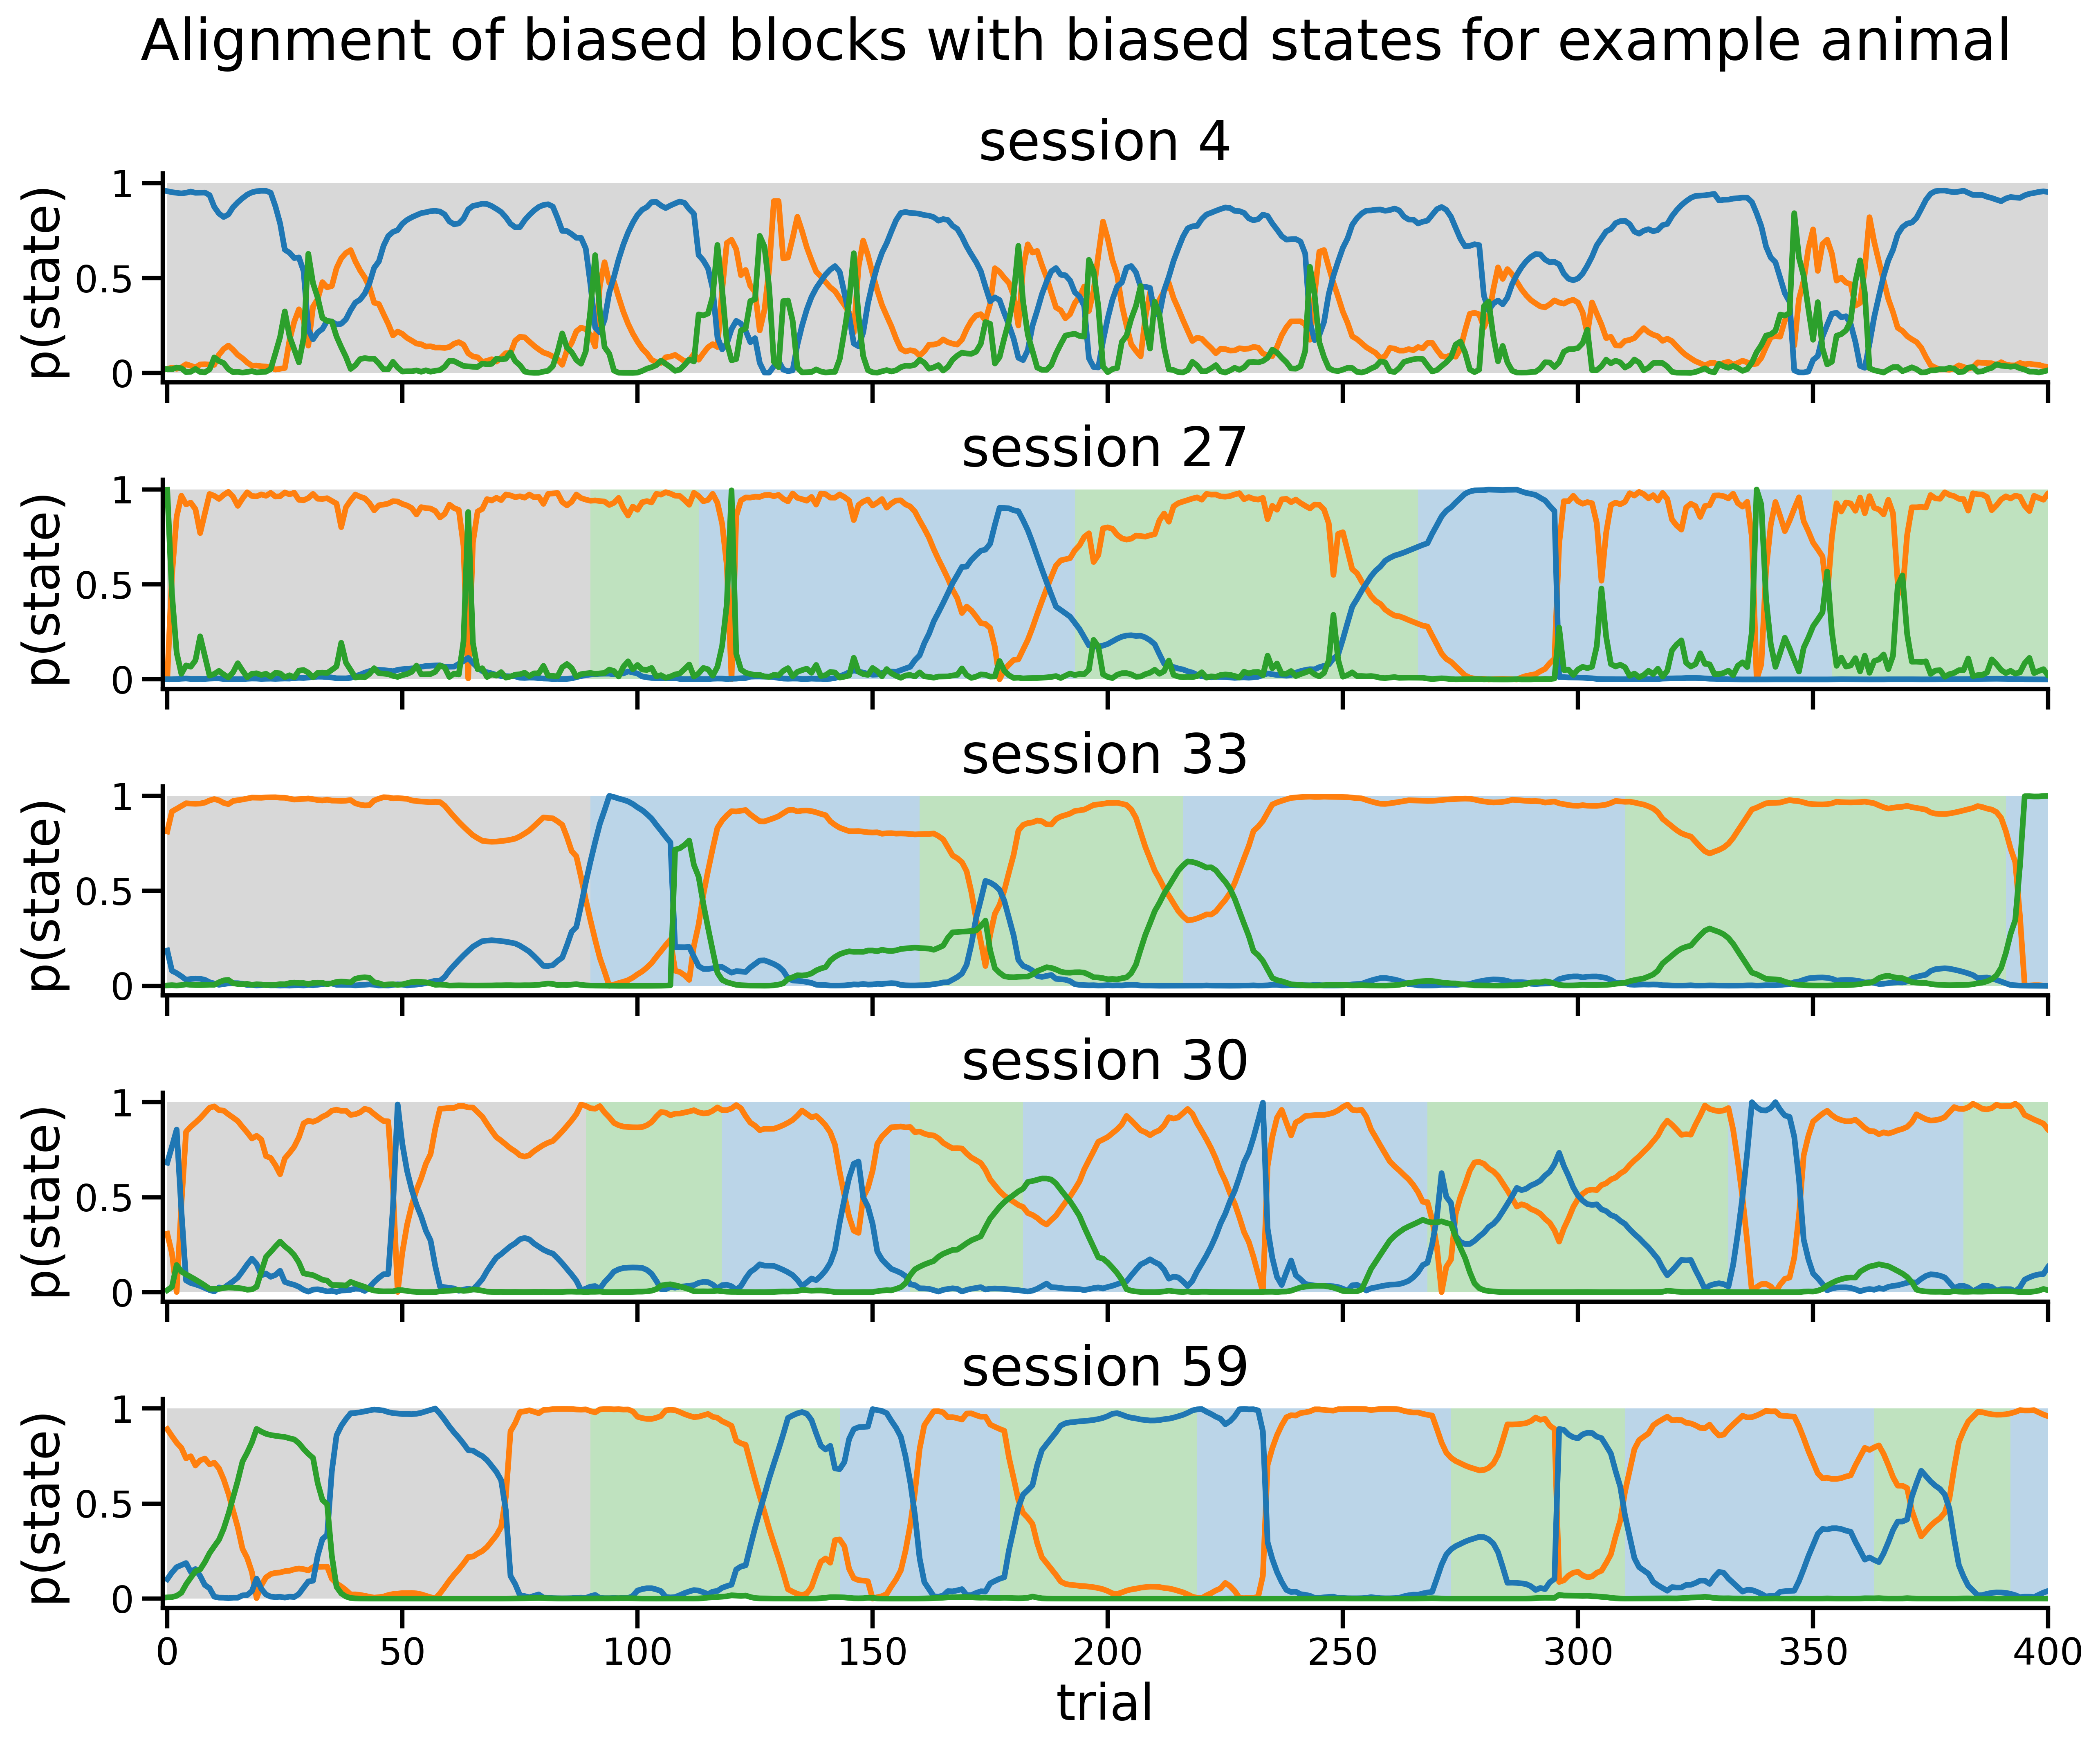

In [95]:
example_subject = 'ibl_witten_015'
example_idx_subject = 30
sessionsInterest = [3,26, 32,29,58]#,27,28,37,40,56,57,58,59,60,61,62,63,64,65,66,67,68,69]
dict_colors = {0:'gray',1:'tab:blue',-1:'tab:green'}
fig, axes = plt.subplots(len(sessionsInterest), 1, figsize=(13,10), dpi=400, sharex=True)
fig.tight_layout(pad=1.5)
plot_posteior_latent(allGamma[example_idx_subject], sessInd, axes, sessions = sessionsInterest, linewidth=2.5)
for s in range(0,len(sessionsInterest)):
    sess = sessionsInterest[s]
    flag = 0
    old = sessInd[sess]
    for t in range(sessInd[sess],sessInd[sess+1]):
        if biasedBlockTrials[t] != flag:
            axes[s].add_patch(Rectangle((old-sessInd[sess], 0), t-old, 1, facecolor=dict_colors[flag], fill=True, alpha=0.3, zorder=0))
            old = t
            flag = biasedBlockTrials[t]
    # last biased block
    axes[s].add_patch(Rectangle((old-sessInd[sess], 0), sessInd[sess+1]-1-old, 1, facecolor=dict_colors[flag], fill=True, alpha=0.3, zorder=0))       
    
    axes[s].set_xlim(-1,400)
    axes[s].spines[['right', 'top']].set_visible(False)
    axes[s].get_legend().remove()
    axes[s].set_ylabel('p(state)', size=22)
    axes[s].set_yticks([0,0.5,1],[0,0.5,1])
axes[-1].set_xlabel('trial', size=22)
fig.suptitle('Alignment of biased blocks with biased states for example animal', size=25, y=1.05)
# fig.tight_layout()
plt.savefig(f'../figures/posterior_latent_example-sessions_{subject}_biased-blocks', bbox_inches='tight', dpi=400)


In [89]:
best = arrAlignLeft[example_idx_subject] + arrAlignRight[example_idx_subject]
print(best)
print(np.argsort(best))

[0.7752025626530996 nan nan nan nan 0.9158756746696446 nan -- -- --
 1.2891826923076923 1.6200859950859952 1.9193548387096775 --
 1.608481262327416 -- nan nan 0.7126436781609196 1.3928974979822437
 1.6803751803751803 -- -- 1.543643410852713 0.867816091954023
 1.6868185493990686 1.1076023391812866 nan nan 1.7933673469387754
 1.8040313549832026 nan]
[18  0 24  5 26 10 19 23 14 11 20 25 29 30 12 28 27 21 22 15 16 13  9  8
  7  6  4  3  2  1 17 31]
